# 02 — Entrenamiento (Modelo_C_fast_lr)

Este notebook entrena **un modelo** con una configuración específica (hiperparámetros).
- Reutiliza los mismos splits (`train_split.csv`, `val_split.csv`) de `OUT_DIR_SPLITS`
- Guarda checkpoints y logs en `OUT_DIR_RUN` (carpeta separada por experimento)

In [10]:
        # ===== PARÁMETROS DEL EXPERIMENTO: Modelo_C_fast_lr =====
        import os, json, random
        import numpy as np
        import torch
        import pandas as pd

        # Carpeta donde quedaron los splits y config_runtime.json del notebook 01
        OUT_DIR_SPLITS = r"C:\Users\User\Downloads\COVID_HYBRID_experiment2"

        # Carpeta de salida SOLO para este experimento (checkpoints, métricas, etc.)
        OUT_DIR_RUN = os.path.join(OUT_DIR_SPLITS, "runs", "Modelo_C_fast_lr")
        os.makedirs(OUT_DIR_RUN, exist_ok=True)

        # Cargar config base (IMG_SIZE, etc.)
        with open(os.path.join(OUT_DIR_SPLITS, "config_runtime.json"), "r", encoding="utf-8") as f:
            cfg = json.load(f)

        SEED = cfg["SEED"]; IMG_SIZE = cfg["IMG_SIZE"]; BATCH_SIZE = cfg["BATCH_SIZE"]; NUM_WORKERS = cfg["NUM_WORKERS"]
        CLASS_NAMES = cfg["CLASS_NAMES"]

        # Reproducibilidad
        random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(SEED)

        DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        print("DEVICE:", DEVICE)

        # Cargar splits (NO se recalculan aquí)
        train_df = pd.read_csv(os.path.join(OUT_DIR_SPLITS, "train_split.csv"))
        val_df   = pd.read_csv(os.path.join(OUT_DIR_SPLITS, "val_split.csv"))

        print("Splits cargados:", len(train_df), len(val_df))

        # ===== OVERRIDES (hiperparámetros) =====
        HYPERPARAMS = dict(
    EPOCHS=25,
    BASE_LR=5e-4,
    VIT_LR=5e-5,
    WEIGHT_DECAY=1e-5,
    PATIENCE=5,
    FREEZE_VIT_EPOCHS=3
)


        # Guardar la config del experimento
        exp_cfg = dict(run_name="Modelo_C_fast_lr", BATCH_SIZE=BATCH_SIZE, NUM_WORKERS=NUM_WORKERS, IMG_SIZE=IMG_SIZE, **HYPERPARAMS)
        with open(os.path.join(OUT_DIR_RUN, "hparams.json"), "w", encoding="utf-8") as f:
            json.dump(exp_cfg, f, ensure_ascii=False, indent=2)

        print("OUT_DIR_RUN:", OUT_DIR_RUN)
        print("HYPERPARAMS:", HYPERPARAMS)

        OUT_DIR = OUT_DIR_RUN


DEVICE: cuda
Splits cargados: 6909 1220
OUT_DIR_RUN: C:\Users\User\Downloads\COVID_HYBRID_experiment2\runs\Modelo_C_fast_lr
HYPERPARAMS: {'EPOCHS': 25, 'BASE_LR': 0.0005, 'VIT_LR': 5e-05, 'WEIGHT_DECAY': 1e-05, 'PATIENCE': 5, 'FREEZE_VIT_EPOCHS': 3}


In [12]:
# ===== FIX: exportar HYPERPARAMS a variables usadas por el entrenamiento =====
# (esto evita NameError al separar notebooks)
BASE_LR            = float(HYPERPARAMS["BASE_LR"])
EPOCHS             = int(HYPERPARAMS["EPOCHS"])
WEIGHT_DECAY       = float(HYPERPARAMS["WEIGHT_DECAY"])
PATIENCE           = int(HYPERPARAMS["PATIENCE"])
FREEZE_VIT_EPOCHS  = int(HYPERPARAMS.get("FREEZE_VIT_EPOCHS", 0))
VIT_LR             = float(HYPERPARAMS.get("VIT_LR", BASE_LR * 0.1))

# Loss config (defínelo aquí para que sea explícito y reproducible)
LABEL_SMOOTH = float(HYPERPARAMS.get("LABEL_SMOOTH", 0.05))
USE_FOCAL    = bool(HYPERPARAMS.get("USE_FOCAL", True))

MAX_STEPS = None

# FocalLoss extra (si aplica)
FOCAL_GAMMA  = float(HYPERPARAMS.get("FOCAL_GAMMA", 2.0))
# Alpha por clase (No-COVID, COVID). Ajusta si tu balance es distinto.
FOCAL_ALPHA  = HYPERPARAMS.get("FOCAL_ALPHA", [1.0, 1.2])

print("BASE_LR:", BASE_LR, "| VIT_LR:", VIT_LR, "| EPOCHS:", EPOCHS, "| WD:", WEIGHT_DECAY)
print("FREEZE_VIT_EPOCHS:", FREEZE_VIT_EPOCHS, "| LABEL_SMOOTH:", LABEL_SMOOTH, "| USE_FOCAL:", USE_FOCAL)


BASE_LR: 0.0005 | VIT_LR: 5e-05 | EPOCHS: 25 | WD: 1e-05
FREEZE_VIT_EPOCHS: 3 | LABEL_SMOOTH: 0.05 | USE_FOCAL: True


In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class XRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        p = self.df.iloc[idx]["path"]; y = int(self.df.iloc[idx]["label"])
        img = Image.open(p).convert("L").convert("RGB")
        if self.transform: img = self.transform(img)
        return img, y

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(7),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

train_loader = DataLoader(
    XRayDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda")
)
val_loader = DataLoader(
    XRayDataset(val_df, eval_tfms),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda")
)

print("Sanity:", next(iter(train_loader))[0].shape)


Sanity: torch.Size([12, 3, 224, 224])


In [15]:
# ===== CELDA 5: MODELO HÍBRIDO + ETAPA A =====
import torch.nn as nn
from torchvision.models import resnext50_32x4d, vit_b_16
import torchvision, inspect

# detectar si vit_b_16 acepta image_size
supports_imgsize = False
try:
    supports_imgsize = "image_size" in inspect.signature(torchvision.models.vit_b_16).parameters
except Exception:
    supports_imgsize = False
if not supports_imgsize and IMG_SIZE != 224:
    print("Esta versión de torchvision no permite image_size en ViT; usando IMG_SIZE=224.")
    IMG_SIZE = 224  # ajuste silencioso; transforms ya usan IMG_SIZE

class HybridRxViT(nn.Module):
    def __init__(self, n_classes=2, img_size=224):
        super().__init__()
        self.resnext = resnext50_32x4d(weights=None)
        self.vit     = vit_b_16(weights=None, image_size=img_size) if supports_imgsize else vit_b_16(weights=None)

        res_feat_dim = self.resnext.fc.in_features
        self.resnext.fc = nn.Identity()
        vit_feat_dim = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Identity()

        fused_dim = res_feat_dim + vit_feat_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(fused_dim),
            nn.Dropout(0.4),                         # ↑ regularización leve
            nn.Linear(fused_dim, 512), nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(512, n_classes)
        )
        # init del clasificador
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        f = torch.cat([self.resnext(x), self.vit(x)], dim=1)
        return self.classifier(f)

model = HybridRxViT(n_classes=2, img_size=IMG_SIZE).to(DEVICE)

# helpers de congelado
def freeze(module, flag=True):
    for p in module.parameters(): p.requires_grad = not (flag)

# ETAPA A: ViT congelado + layer1/2 de ResNeXt congeladas
freeze(model.vit, True)
freeze(model.resnext.layer1, True)
freeze(model.resnext.layer2, True)
for p in model.classifier.parameters(): p.requires_grad = True

def count_trainable(m): 
    return sum(p.numel() for p in m.parameters() if p.requires_grad)/1e6
print(f"Entrenables (Etapa A): {count_trainable(model):.1f} M")


Entrenables (Etapa A): 23.0 M


In [17]:
# ===== CELDA 6: LOSS + OPTIM + SCHED =====
import torch.nn as nn
import torch.optim as optim


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction="mean", label_smoothing=0.0):
        super().__init__()
        self.gamma, self.alpha, self.reduction = gamma, alpha, reduction
        self.ce = nn.CrossEntropyLoss(weight=alpha, reduction="none", label_smoothing=label_smoothing)
    def forward(self, logits, targets):
        ce = self.ce(logits, targets)  
        pt = torch.exp(-ce)            
        loss = ((1-pt)**self.gamma) * ce
        if self.reduction=="mean": return loss.mean()
        if self.reduction=="sum":  return loss.sum()
        return loss

USE_FOCAL = True
alpha = torch.tensor(FOCAL_ALPHA, device=DEVICE) if USE_FOCAL else None  
criterion = FocalLoss(gamma=FOCAL_GAMMA, alpha=alpha, label_smoothing=LABEL_SMOOTH) if USE_FOCAL else nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

param_groups = [
    {"params": [p for p in model.resnext.parameters() if p.requires_grad],    "lr": BASE_LR*0.7},
    {"params": [p for p in model.vit.parameters()     if p.requires_grad],    "lr": BASE_LR*0.3},
    {"params": model.classifier.parameters(),                                  "lr": BASE_LR}
]
optimizer = optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)

# Warmup + Cosine
warmup_epochs = 3
def lr_lambda(ep):
    if ep < warmup_epochs: return (ep+1)/warmup_epochs
    prog = (ep - warmup_epochs) / max(1,(EPOCHS - warmup_epochs))
    return 0.5*(1+math.cos(math.pi*prog))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

best_val, wait = float("inf"), 0
ckpt_path = os.path.join(OUT_DIR, "best_hybrid_exp2.pt")


Epoch 20 | Train 0.0540/0.9495 | Val 0.0343/0.9648 | 843.0s | LR 1.50e-04


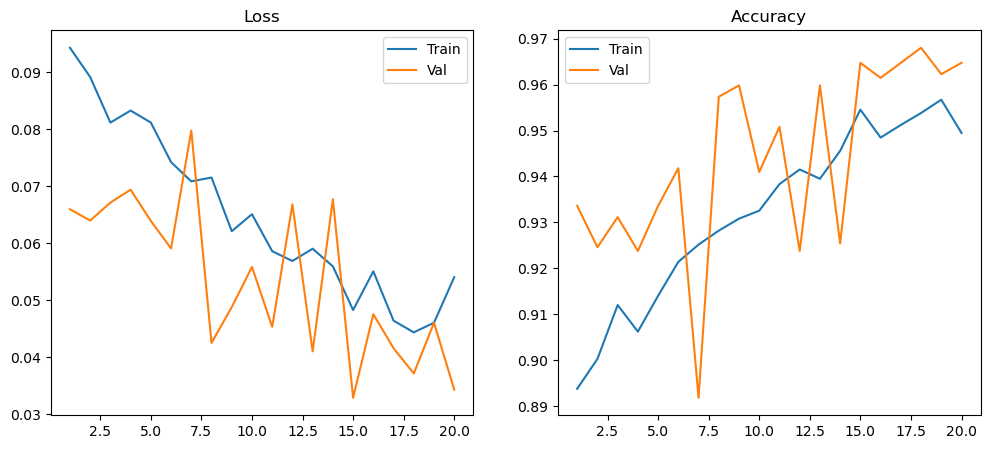

Early stopping.
Mejor val_loss: 0.032871343254981956 | checkpoint: C:\Users\User\Downloads\COVID_HYBRID_experiment2\runs\Modelo_C_fast_lr\Ve.pt


In [22]:
# ===== CELDA 7: TRAIN LOOP =====
from time import time
from IPython.display import clear_output
from contextlib import nullcontext
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import math

use_cuda = (DEVICE=="cuda")
scaler = torch.amp.GradScaler("cuda", enabled=use_cuda)
history = []

def run_epoch(loader, train=True, epoch=0, phase="train", max_steps=None):
    model.train(train)
    ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if use_cuda else nullcontext()
    total_loss = total = correct = 0
    steps = 0
    bar = tqdm(loader, leave=False, desc=f"Epoch {epoch:02d} [{phase}]", ncols=80)
    for imgs, labels in bar:
        imgs, labels = imgs.to(DEVICE, non_blocking=use_cuda), labels.to(DEVICE, non_blocking=use_cuda)
        try:
            with ctx:
                logits = model(imgs)
                loss = criterion(logits, labels)
            if train:
                optimizer.zero_grad(set_to_none=True)
                if use_cuda:
                    scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
                else:
                    loss.backward(); optimizer.step()
        except torch.cuda.OutOfMemoryError:
            torch.cuda.empty_cache(); continue
        total_loss += loss.item() * imgs.size(0)
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += imgs.size(0)
        steps += 1
        bar.set_postfix(loss=f"{total_loss/total:.4f}", acc=f"{correct/total:.4f}")
        if max_steps is not None and steps >= max_steps: break
    return total_loss/total, correct/total

for epoch in range(1, EPOCHS+1):
    t0 = time()

    if epoch == 11:  
        freeze(model.resnext, False); freeze(model.vit, True)
        # actualizar param groups (ahora hay más params entrenables en ResNeXt)
        optimizer = torch.optim.AdamW([
            {"params": [p for p in model.resnext.parameters() if p.requires_grad], "lr": BASE_LR*0.7},
            {"params": [p for p in model.vit.parameters()     if p.requires_grad], "lr": BASE_LR*0.3},
            {"params": model.classifier.parameters(),                             "lr": BASE_LR}
        ], weight_decay=WEIGHT_DECAY)
        print(">> Etapa B: ResNeXt full, ViT congelado")

    if epoch == 16:  
        freeze(model.vit, False)
        optimizer = torch.optim.AdamW([
            {"params": model.resnext.parameters(), "lr": BASE_LR*0.6},
            {"params": model.vit.parameters(),     "lr": BASE_LR*0.3},  # LR menor para ViT
            {"params": model.classifier.parameters(), "lr": BASE_LR}
        ], weight_decay=WEIGHT_DECAY)
        print(">> Etapa C: todo entrenable (LR ViT bajo)")

    tr_loss, tr_acc = run_epoch(train_loader, True,  epoch, "train", max_steps=MAX_STEPS)
    val_loss, val_acc = run_epoch(val_loader,   False, epoch, "val",   max_steps=None)

    scheduler.step()

    history.append({"epoch": epoch, "train_loss": tr_loss, "train_acc": tr_acc,
                    "val_loss": val_loss, "val_acc": val_acc})

    clear_output(wait=True)
    print(f"Epoch {epoch:02d} | Train {tr_loss:.4f}/{tr_acc:.4f} | "
          f"Val {val_loss:.4f}/{val_acc:.4f} | {time()-t0:.1f}s | LR {scheduler.get_last_lr()[0]:.2e}")

    hist_df = pd.DataFrame(history)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(hist_df["epoch"], hist_df["train_loss"], label="Train"); plt.plot(hist_df["epoch"], hist_df["val_loss"], label="Val"); plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2); plt.plot(hist_df["epoch"], hist_df["train_acc"], label="Train"); plt.plot(hist_df["epoch"], hist_df["val_acc"], label="Val"); plt.legend(); plt.title("Accuracy")
    plt.show()

    if val_loss < best_val - 1e-4:
        best_val, wait = val_loss, 0
        torch.save({"model": model.state_dict(), "class_names": CLASS_NAMES, "IMG_SIZE": IMG_SIZE}, 
                   os.path.join(OUT_DIR, "best_hybrid_exp2.pt"))
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping."); break

ckpt_path = os.path.join(OUT_DIR, "Ve.pt")
print("Mejor val_loss:", best_val, "| checkpoint:", ckpt_path)


